In [11]:
from math import sqrt
from skimage import data, io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import filters
from scipy import ndimage

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [5]:
os.getcwd()

'/Users/yichen/Desktop/Murray_Lab'

In [6]:
os.path.isdir('/Users/yichen/Desktop/Murray_Lab/sic1_evolution_exp/fluct_test')


True

In [7]:
path = '/Users/yichen/Desktop/Murray_Lab/sic1_evolution_exp/fluct_test/*_pub.tif'
im_test = io.imread_collection(path)
print(len(im_test))

4


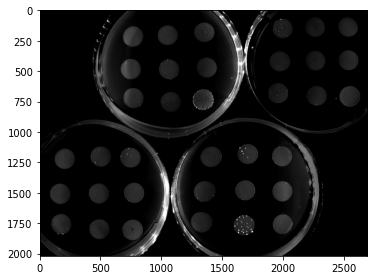

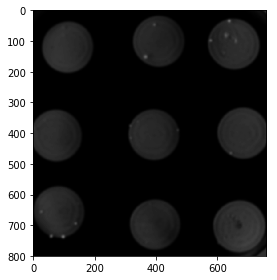

In [29]:
image = im_test[0]
image_gray = rgb2gray(image)
image_gray = ndimage.gaussian_filter(image_gray, sigma = 3)
io.imshow(image_gray)
plt.show()

#crop images
y1 = 90
y2 = 850
x1 = 1100
x2 = 1900
cropped = image_gray[x1:x2,y1:y2]
io.imshow(cropped)

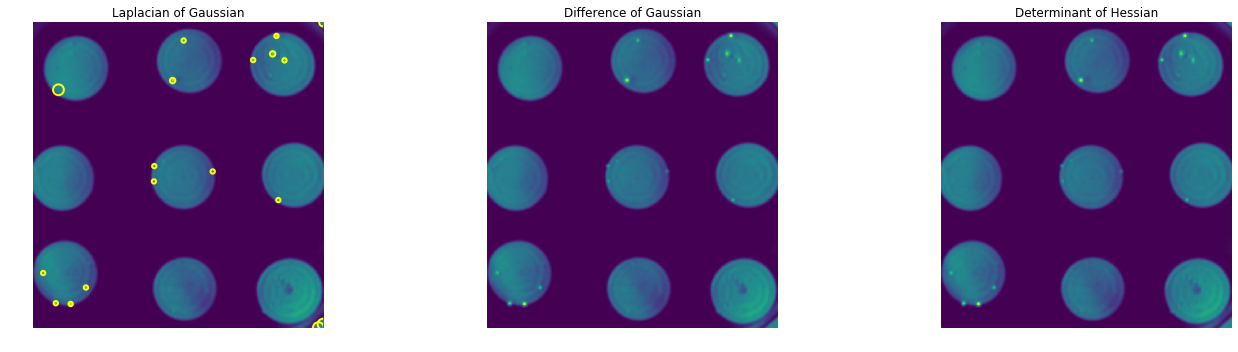

In [36]:
image_gray = cropped
image = cropped

# Compute radii in the 3rd column.
blobs_log = blob_log(image_gray, max_sigma=10, num_sigma=10, threshold=.05)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=10, threshold=.5)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=10, threshold=.005)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)


fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

# Fluctuation analysis and methods:

MSS maximum likelihood method (Method 5) is the gold standard because it utilizes all of the results of an experiment and is valid over the entire range of mutation rates. The Lea-Coulson method of the median (Method 2) and the Jones median estimator (Method 3) are reliable when mutation rates are low to moderate, and the p0 method (Method 1) can be used when mutation rates are very low (m ≤1). Drake’s Formula (Method 4) is particularly useful when comparing data reported as mutant frequencies instead of mutation rates. 

## MSS maximum likelihood method of fluctatuation test analysis

https://www-ncbi-nlm-nih-gov.ezp-prod1.hul.harvard.edu/pmc/articles/PMC2041832/#FD1

### Define parameters of model:
- m, number of mutations per culture
- r, number of observed mutants per culture
- $N_{0}$ initial number of cells
- $N_{t}$ final number of cells


In [160]:
import math
import logging
from collections import Counter
from collections import namedtuple
from statistics import median

from scipy import optimize


# All notations were taken from article [Foster, 2006]

# Full list of references:
#
# Foster, P.L. (2006). Methods for Determining Spontaneous Mutation Rates.
#
# Sarkar, S., Ma, W. T., and Sandri, G.v.H. (1992). On fluctuation analysis: A new, simple
#     and efficient method for computing the expected number of mutants.
#
# Lea, D. E., and Coulson, C. A. (1949). The distribution of the numbers of mutants
#     in bacterial populations.
#
# Stewart, F. M. (1994). Fluctuation tests: How reliable are the estimates of mutation rates?
#
# Stewart, F. M., Gordon, D. M., and Levin, B. R. (1990). Fluctuation analysis:
#     The probability distribution of the number of mutants under different conditions.


logger = logging.getLogger(__name__)


Interval = namedtuple('Interval', ['lower', 'upper'])


def cultures_with_mutants_ratio(m):
    """ Returns function p(r) for calculation proportion of cultures with `r` mutants with given m.
    Denoted by p_r.

    Recursive algorithm were taken from [Sarkar et al., 1992].

    :param m: number of mutations per culture
    :param r: observed number of mutants in a culture
    :return: p_r for given m; 0 <= p_r <= 1
    """
    cache = []

    def p(target_r):
        if not cache:
            cache.append(math.exp(-m))

        if len(cache) <= target_r:
            for r in range(len(cache), target_r + 1):
                cache.append(m / r * sum(cache[i] / (r + 1 - i) for i in range(r)))

        return cache[target_r]
    return p


def m_mle_estimation(r_observed):
    """ Calculate estimated value for number of mutants per culture by MSS-MLE
    (Ma-Sandri-Sarkar Maximum Likelihood Estimator).

    Likelihood function were taken from [Foster, 2006] with log transformation.

    :param r_observed: list of observed number of mutants
    :return: estimated value for number of mutants per culture
    """
    def min_log_likelihood(m, counts=Counter(r_observed)):
        logger.info('Estimated m: %s', m)
        p = cultures_with_mutants_ratio(m)
        return -sum(counts[r] * math.log(p(r))
                    for r in range(math.ceil(max(counts)) + 1)
                    if counts[r] != 0)

    start_guess = _get_start_m_approximation(r_observed)
    return _optimize_positive_value(min_log_likelihood, guess=start_guess)


def mutation_rate_limits(m, c, n_total):
    """ [Foster 2006]
    :param c: count of cultures; denoted by C
    :param m: number of mutations per culture
    :param n_total: total number of cells in culture
    """

    sigma = 1.225 * m ** (-0.315) / c ** 0.5

    lower = math.exp(math.log(m) - 1.96 * sigma * math.exp(1.96 * sigma) ** 0.315)
    upper = math.exp(math.log(m) + 1.96 * sigma * math.exp(1.96 * sigma) ** (-0.315))

    return Interval(lower / n_total, upper / n_total)


def calc_estimated_mutants(r_observed, *, z=1):
    """ Calculate estimated number of mutants per culture with plating efficiency correction.

    Plating efficiency correction were taken from [Steward, 1990]

    :param r_observed: list of observed number of mutants
    :param z: fraction of a culture plated (plating efficiency); 0 < z <= 1
    :return: number of mutants per culture
    """
    return m_mle_estimation(r_observed) * plating_efficiency_multiplier(z)


def calc_mutation_rate(m, mean_cells_in_culture):
    """ Calculate mutation rate (denoted by mu) with plating efficiency correction.

    mu = m / (mean number of cells in culture)
    where m is a number of mutants per culture.

    :param m: a number of mutants per culture
    :param mean_cells_in_culture: mean number of cells in culture
    :return: mu with confidence interval tuple: (mu, Interval)
    """
    return m / mean_cells_in_culture


def plating_efficiency_multiplier(z):
    """ Plating efficiency correction multiplier for number of mutations per culture
    from [Steward, 1990].

    z is the probability that any given mutant cell will generate a colony.

    :param z: fraction of a culture plated (plating efficiency); 0 < z <= 1
    :return: correction multiplier for number of mutations per culture
    """
    assert 0 < z <= 1
    if z == 1:
        return 1  # by l'Hôpital's rule
    return (z - 1) / (z * math.log(z))


def frequency(observed_mutant_count, number_of_cells):
    """ Calculate mutation fraction (or frequency) per culture.

    Frequency calculated as r/N.
    where r is observed number of mutants
          N is a number of cells in a culture

    :param observed_mutant_count: observed number of mutants in a culture
    :param number_of_cells: number of cells in a culture
    :return: mutation fraction per culture
    """
    return observed_mutant_count / number_of_cells


def _optimize_positive_value(func, *, guess):
    """ argmin(func), where func: R+ -> R """
    return optimize.minimize(lambda x: func(x[0]), [guess], bounds=[(1e-10, None)])['x'][0]


def _get_start_m_approximation(r_observed):
    """ Get good start guess point for number of mutations per culture.

    Calculate start approximation of m by equation from [Lea, Coulson, 1945].

    :param r_observed: list of observed number of mutants
    :return: approximation of number of mutations per culture
    """
    def calc_estimation(m):
        return abs(r_median / m - math.log(m) - 1.24)

    r_median = median(r_observed)

    # 0.3 is our default guess for mutants count per culture
    return min(_optimize_positive_value(calc_estimation, guess=0.3), 500)


In [168]:
sic1 = [76, 57, 251, 14, 16, 238, 29, 58, 31, 22, 10, 48, 47, 44, 34, 55, 10, 52, 46, 5, 19, 150, 25, 26, 25, 31, 42, 150, 250, 30, 11, 23, 43, 12, 14, 45, 261, 146, 15, 21, 18, 8, 13, 27, 9, 21, 29, 14, 161, 28, 154, 171, 121, 52, 47, 76, 78,  36, 34, 55, 17, 19, 21, 32, 76, 261, 28, 13]
WT = [1, 2, 1, 16, 2, 3, 1, 10, 0, 0, 0, 0, 1, 5, 4, 2, 3, 1, 5, 1, 6, 2, 0, 0, 6, 8, 8, 2, 5, 0, 28, 2, 8, 1, 1, 2, 1, 1, 1, 7, 11, 1, 0, 0, 1, 2, 1, 3, 28, 0, 3, 12, 0, 0, 0, 0, 2, 1, 1, 51, 3, 0, 0, 2, 1, 0, 48, 2, 0, 0] 


In [169]:
WT_m = m_mle_estimation(WT)
WT_mu = calc_mutation_rate(m_mle_estimation(WT), 10e7)
WT_lim = mutation_rate_limits(m_mle_estimation(WT), len(WT), 10e7)

print(WT_mu)
print(WT_lim)

sic1_m = m_mle_estimation(sic1)
sic1_mu = calc_mutation_rate(m_mle_estimation(sic1), 10e7)
sic1_lim = mutation_rate_limits(m_mle_estimation(sic1), len(sic1), 10e7)

print(sic1_mu)
print(sic1_lim)

1.1576548526370791e-08
Interval(lower=8.586860336846125e-09, upper=1.4885070382075683e-08)
9.366532318339286e-08
Interval(lower=8.057145686911422e-08, upper=1.0747516876446084e-07)
